In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

In [2]:
# download from https://evictionlab.org/get-the-data/
# Choose VA => choose "all.csv" (Change the file name to 'VA.csv')
# Choose VA => choose "cities.csv" (Change the file name to 'cities_VA.csv')
df = pd.read_csv('block-groups_VA.csv')

In [3]:
df_clean = df.dropna(axis=0, how='any')

In [4]:
df_clean = df_clean[df_clean['eviction-rate']<100]

In [5]:
HighRankCity = ['Richmond city, Virginia', 'Hampton city, Virginia', 'Newport News city, Virginia', 'Norfolk city, Virginia', 'Chesapeake city, Virginia']

In [6]:
df_clean.columns

Index(['GEOID', 'year', 'name', 'parent-location', 'population',
       'poverty-rate', 'pct-renter-occupied', 'median-gross-rent',
       'median-household-income', 'median-property-value', 'rent-burden',
       'pct-white', 'pct-af-am', 'pct-hispanic', 'pct-am-ind', 'pct-asian',
       'pct-nh-pi', 'pct-multiple', 'pct-other', 'renter-occupied-households',
       'eviction-filings', 'evictions', 'eviction-rate',
       'eviction-filing-rate', 'imputed', 'subbed'],
      dtype='object')

In [7]:
# df_city=df_clean[(df_clean['name']==HighRankCity[0]) | (df_clean['name']==HighRankCity[1]) | (df_clean['name']==HighRankCity[2]) | (df_clean['name']==HighRankCity[3]) | (df_clean['name']==HighRankCity[4])]

In [8]:
df_city=df_clean[df_clean['parent-location']==HighRankCity[0]]   # Analyze 'Richmond city, Virginia' first

df_city_2016=df_clean[(df_clean['parent-location']==HighRankCity[0]) & (df_clean['year']==2016)]

df_city_2016.shape

(130, 26)

# Analyze Richmond city, Virginia in 2016

In [9]:
X = df_city_2016.drop(['GEOID','year','name','parent-location','imputed','subbed','eviction-rate','eviction-filings','evictions','eviction-filing-rate'],axis=1)
y = df_city_2016['eviction-rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

rfc = RandomForestRegressor(n_estimators=100)

rfc.fit(X_train,y_train)

predictions = rfc.predict(X_test)

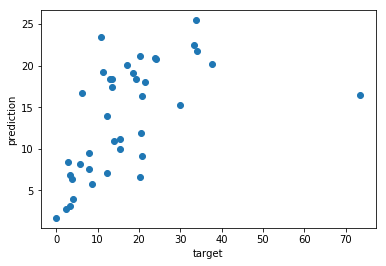

In [10]:
plt.scatter(y_test,predictions)
plt.xlabel("target")
plt.ylabel("prediction")
ymin = np.round( min( min(y_test), min(predictions) ) )
ymax = np.ceil( max( max(y_test), max(predictions) ) )

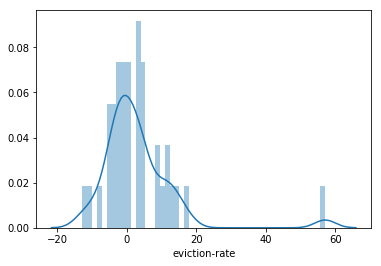

In [11]:
sns.distplot((y_test-predictions),bins=50);

In [12]:
print("Training set score: %.10f" % rfc.score(X_train, y_train))
print("Test set score: %.10f" % rfc.score(X_test, y_test))

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

Training set score: 0.9203533856
Test set score: 0.2545397216
MAE: 6.66915641026
MSE: 131.45415642
RMSE: 11.4653458918


Feature ranking:
1. feature 8 (pct-af-am) (0.460535)
2. feature 2 (pct-renter-occupied) (0.120105)
3. feature 7 (pct-white) (0.116255)
4. feature 5 (median-property-value) (0.054284)
5. feature 0 (population) (0.044806)
6. feature 3 (median-gross-rent) (0.037658)
7. feature 13 (pct-multiple) (0.033434)
8. feature 1 (poverty-rate) (0.028327)
9. feature 6 (rent-burden) (0.024326)
10. feature 10 (pct-am-ind) (0.018014)
11. feature 15 (renter-occupied-households) (0.017961)
12. feature 9 (pct-hispanic) (0.016286)
13. feature 4 (median-household-income) (0.013985)
14. feature 11 (pct-asian) (0.010159)
15. feature 12 (pct-nh-pi) (0.003379)
16. feature 14 (pct-other) (0.000486)


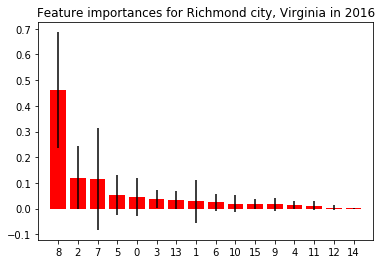

In [13]:
importances = rfc.feature_importances_

std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%s) (%f)" % (f + 1,indices[f], X.columns[indices[f]], importances[indices[f]]))
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances for Richmond city, Virginia in 2016")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [14]:
ds_importances = pd.Series(importances, name='importances')
ds_std = pd.Series(std, name='std')
ds_columns = pd.Series(X.columns,name='features')
Results = pd.concat([ds_importances, ds_std,ds_columns], axis=1)
Results.to_csv('Result_VA_RichmondCity_2016_rf_all.csv')

In [15]:
# do a quick baseline test
baseline = LinearRegression()
single_tree = DecisionTreeRegressor()
print("CV single tree:", cross_val_score(single_tree, X_train, y_train).mean())
print("CV baseline:", cross_val_score(baseline,X_train, y_train).mean())
print("CV forest:", cross_val_score(rfc, X_train, y_train).mean())

CV single tree: -0.0316947794644
CV baseline: 0.0611598543497
CV forest: 0.468808440392


In [16]:
# test score
single_tree.fit(X_train, y_train)
baseline.fit(X_train, y_train)
print("test score single tree:", single_tree.score(X_test, y_test))
print("test score baseline:", baseline.score(X_test, y_test))
print("test score forest:", rfc.score(X_test, y_test))

test score single tree: 0.0636532368986
test score baseline: 0.114539118092
test score forest: 0.254539721649


# Use pct-af-am race only

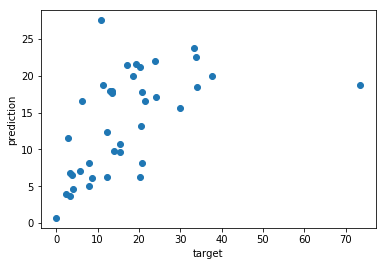

In [17]:
X = df_city_2016.drop(['GEOID','year','name','parent-location','imputed','subbed','eviction-rate','eviction-filings','evictions','eviction-filing-rate',
                      'renter-occupied-households','pct-nh-pi','pct-other','pct-am-ind','pct-white','population','pct-hispanic','pct-multiple','pct-asian'],axis=1)
y = df_city_2016['eviction-rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

rfc = RandomForestRegressor(n_estimators=100)
rfc.fit(X_train,y_train)

predictions = rfc.predict(X_test)
plt.scatter(y_test,predictions)
plt.xlabel("target")
plt.ylabel("prediction")
ymin = np.round( min( min(y_test), min(predictions) ) )
ymax = np.ceil( max( max(y_test), max(predictions) ) )

In [18]:
print("Training set score: %.10f" % rfc.score(X_train, y_train))
print("Test set score: %.10f" % rfc.score(X_test, y_test))
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

Training set score: 0.9183107681
Test set score: 0.2397141772
MAE: 7.08899487179
MSE: 134.06848679
RMSE: 11.5787947037


Feature ranking:
1. feature 6 (pct-af-am) (0.579487)
2. feature 1 (pct-renter-occupied) (0.152684)
3. feature 4 (median-property-value) (0.069323)
4. feature 0 (poverty-rate) (0.064186)
5. feature 2 (median-gross-rent) (0.056937)
6. feature 3 (median-household-income) (0.040183)
7. feature 5 (rent-burden) (0.037200)


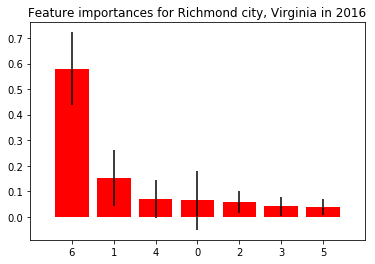

In [19]:
importances = rfc.feature_importances_

std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%s) (%f)" % (f + 1,indices[f], X.columns[indices[f]], importances[indices[f]]))
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances for Richmond city, Virginia in 2016")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [20]:
ds_importances = pd.Series(importances, name='importances')
ds_std = pd.Series(std, name='std')
ds_columns = pd.Series(X.columns,name='features')
Results = pd.concat([ds_importances, ds_std,ds_columns], axis=1)
Results.to_csv('Result_VA_RichmondCity_2016_rf_pct-af-am.csv')

# Analyze Richmond city, Virginia all 2000-2016 years

In [21]:
X = df_city.drop(['GEOID','year','name','parent-location','imputed','subbed','eviction-rate','eviction-filings','evictions','eviction-filing-rate'],axis=1)
y = df_city['eviction-rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

rfc = RandomForestRegressor(n_estimators=100)

rfc.fit(X_train,y_train)

predictions = rfc.predict(X_test)

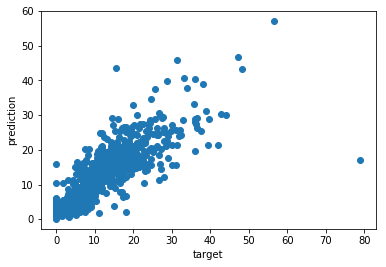

In [22]:
plt.scatter(y_test,predictions)
plt.xlabel("target")
plt.ylabel("prediction")
ymin = np.round( min( min(y_test), min(predictions) ) )
ymax = np.ceil( max( max(y_test), max(predictions) ) )

In [23]:
print("Training set score: %.10f" % rfc.score(X_train, y_train))
print("Test set score: %.10f" % rfc.score(X_test, y_test))

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

Training set score: 0.9483542346
Test set score: 0.6736721963
MAE: 3.50491131078
MSE: 28.0071313017
RMSE: 5.2921764239


Feature ranking:
1. feature 7 (pct-white) (0.388471)
2. feature 15 (renter-occupied-households) (0.142972)
3. feature 8 (pct-af-am) (0.107556)
4. feature 2 (pct-renter-occupied) (0.055744)
5. feature 0 (population) (0.040571)
6. feature 3 (median-gross-rent) (0.038888)
7. feature 4 (median-household-income) (0.038603)
8. feature 9 (pct-hispanic) (0.037000)
9. feature 5 (median-property-value) (0.027192)
10. feature 1 (poverty-rate) (0.023342)
11. feature 6 (rent-burden) (0.022157)
12. feature 11 (pct-asian) (0.019110)
13. feature 14 (pct-other) (0.018435)
14. feature 10 (pct-am-ind) (0.018181)
15. feature 13 (pct-multiple) (0.017116)
16. feature 12 (pct-nh-pi) (0.004662)


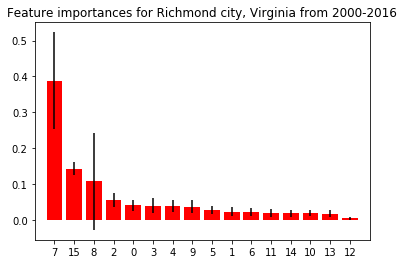

In [24]:
importances = rfc.feature_importances_

std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%s) (%f)" % (f + 1,indices[f], X.columns[indices[f]], importances[indices[f]]))
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances for Richmond city, Virginia from 2000-2016")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [25]:
ds_importances = pd.Series(importances, name='importances')
ds_std = pd.Series(std, name='std')
ds_columns = pd.Series(X.columns,name='features')
Results = pd.concat([ds_importances, ds_std,ds_columns], axis=1)
Results.to_csv('Result_VA_RichmondCity_years_all.csv')

# Use pct-af-am race only

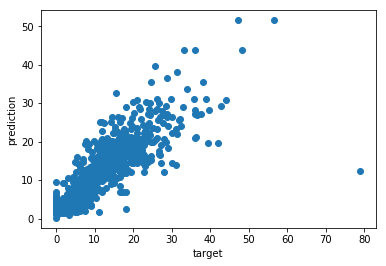

In [26]:
# Use pct-af-am race only
X = df_city.drop(['GEOID','year','name','parent-location','imputed','subbed','eviction-rate','eviction-filings','evictions','eviction-filing-rate',
                      'renter-occupied-households','pct-nh-pi','pct-other','pct-am-ind','pct-white','population','pct-hispanic','pct-multiple','pct-asian'],axis=1)
y = df_city['eviction-rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

rfc = RandomForestRegressor(n_estimators=100)
rfc.fit(X_train,y_train)

predictions = rfc.predict(X_test)
plt.scatter(y_test,predictions)
plt.xlabel("target")
plt.ylabel("prediction")
ymin = np.round( min( min(y_test), min(predictions) ) )
ymax = np.ceil( max( max(y_test), max(predictions) ) )

In [27]:
print("Training set score: %.10f" % rfc.score(X_train, y_train))
print("Test set score: %.10f" % rfc.score(X_test, y_test))
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

Training set score: 0.8379889073
Test set score: 0.6806728387
MAE: 3.43625343036
MSE: 27.4063001449
RMSE: 5.23510268714


Feature ranking:
1. feature 6 (pct-af-am) (0.559414)
2. feature 1 (pct-renter-occupied) (0.094576)
3. feature 3 (median-household-income) (0.092522)
4. feature 4 (median-property-value) (0.077011)
5. feature 2 (median-gross-rent) (0.067028)
6. feature 0 (poverty-rate) (0.061607)
7. feature 5 (rent-burden) (0.047842)


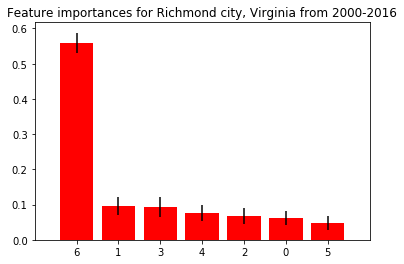

In [28]:
importances = rfc.feature_importances_

std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%s) (%f)" % (f + 1,indices[f], X.columns[indices[f]], importances[indices[f]]))
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances for Richmond city, Virginia from 2000-2016")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [29]:
ds_importances = pd.Series(importances, name='importances')
ds_std = pd.Series(std, name='std')
ds_columns = pd.Series(X.columns,name='features')
Results = pd.concat([ds_importances, ds_std,ds_columns], axis=1)
Results.to_csv('Result_VA_RichmondCity_years_rf_pct-af-am.csv')

In [30]:
# do a quick baseline test
baseline = LinearRegression()
single_tree = DecisionTreeRegressor()
print("CV single tree:", cross_val_score(single_tree, X_train, y_train).mean())
print("CV baseline:", cross_val_score(baseline,X_train, y_train).mean())
print("CV forest:", cross_val_score(rfc, X_train, y_train).mean())

CV single tree: 0.61466623605
CV baseline: 0.406345833003
CV forest: 0.678094419619


In [31]:
# test score
single_tree.fit(X_train, y_train)
baseline.fit(X_train, y_train)
print("test score single tree:", single_tree.score(X_test, y_test))
print("test score baseline:", baseline.score(X_test, y_test))
print("test score forest:", rfc.score(X_test, y_test))

test score single tree: 0.650474273074
test score baseline: 0.369346176501
test score forest: 0.680672838686


# Use pct-white only

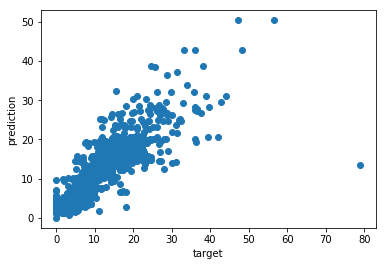

In [32]:
X = df_city.drop(['GEOID','year','name','parent-location','imputed','subbed','eviction-rate','eviction-filings','evictions','eviction-filing-rate',
                      'renter-occupied-households','pct-nh-pi','pct-other','pct-am-ind','pct-af-am','population','pct-hispanic','pct-multiple','pct-asian'],axis=1)
y = df_city['eviction-rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

rfc = RandomForestRegressor(n_estimators=100)
rfc.fit(X_train,y_train)

predictions = rfc.predict(X_test)
plt.scatter(y_test,predictions)
plt.xlabel("target")
plt.ylabel("prediction")
ymin = np.round( min( min(y_test), min(predictions) ) )
ymax = np.ceil( max( max(y_test), max(predictions) ) )

In [33]:
print("Training set score: %.10f" % rfc.score(X_train, y_train))
print("Test set score: %.10f" % rfc.score(X_test, y_test))
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

Training set score: 0.8385438753
Test set score: 0.6835667333
MAE: 3.42058012685
MSE: 27.1579312164
RMSE: 5.21132720297


# Use both pct-white and pct-af-am

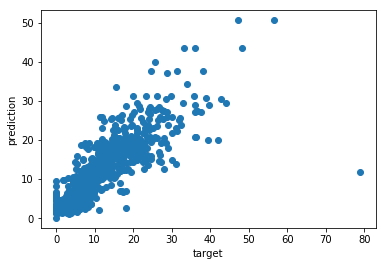

In [34]:
X = df_city.drop(['GEOID','year','name','parent-location','imputed','subbed','eviction-rate','eviction-filings','evictions','eviction-filing-rate',
                      'renter-occupied-households','pct-nh-pi','pct-other','pct-am-ind','population','pct-hispanic','pct-multiple','pct-asian'],axis=1)
y = df_city['eviction-rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

rfc = RandomForestRegressor(n_estimators=100)
rfc.fit(X_train,y_train)

predictions = rfc.predict(X_test)
plt.scatter(y_test,predictions)
plt.xlabel("target")
plt.ylabel("prediction")
ymin = np.round( min( min(y_test), min(predictions) ) )
ymax = np.ceil( max( max(y_test), max(predictions) ) )

In [35]:
print("Training set score: %.10f" % rfc.score(X_train, y_train))
print("Test set score: %.10f" % rfc.score(X_test, y_test))
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

Training set score: 0.8384595373
Test set score: 0.6756858607
MAE: 3.46403258461
MSE: 27.8343082582
RMSE: 5.27582299345


Feature ranking:
1. feature 6 (pct-white) (0.476873)
2. feature 7 (pct-af-am) (0.139598)
3. feature 1 (pct-renter-occupied) (0.095198)
4. feature 2 (median-gross-rent) (0.083145)
5. feature 3 (median-household-income) (0.058737)
6. feature 4 (median-property-value) (0.056555)
7. feature 0 (poverty-rate) (0.045450)
8. feature 5 (rent-burden) (0.044444)


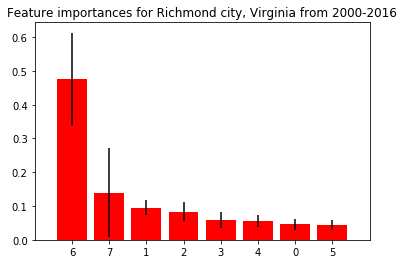

In [36]:
importances = rfc.feature_importances_

std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%s) (%f)" % (f + 1,indices[f], X.columns[indices[f]], importances[indices[f]]))
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances for Richmond city, Virginia from 2000-2016")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [37]:
by_year = df_city.groupby('year')
by_year.mean()

,GEOID,population,poverty-rate,pct-renter-occupied,median-gross-rent,median-household-income,median-property-value,rent-burden,pct-white,pct-af-am,...,pct-nh-pi,pct-multiple,pct-other,renter-occupied-households,eviction-filings,evictions,eviction-rate,eviction-filing-rate,imputed,subbed
year,,,,,,,,,,,,,,,,,,,,,
2000,5.176004e+11,1227.994938,20.420500,50.782313,546.792875,35017.212688,102747.942250,28.388813,36.261500,58.701375,...,0.033062,1.181125,0.155875,280.568750,69.212500,29.675000,11.138750,23.641125,0.0,0.0
2001,5.176004e+11,1227.994938,20.420500,50.782313,546.792875,35017.212688,102747.942250,28.388813,36.261500,58.701375,...,0.033062,1.181125,0.155875,283.031250,77.850000,31.668750,11.912250,26.658000,0.0,0.0
2002,5.176004e+11,1227.994938,20.420500,50.782313,546.792875,35017.212688,102747.942250,28.388813,36.261500,58.701375,...,0.033062,1.181125,0.155875,285.481250,145.350000,35.806250,13.245563,48.312500,0.0,0.0
2003,5.176004e+11,1227.994938,20.420500,50.782313,546.792875,35017.212688,102747.942250,28.388813,36.261500,58.701375,...,0.033062,1.181125,0.155875,287.956250,139.550000,36.587500,13.862125,46.120437,0.0,0.0
2004,5.176004e+11,1227.994938,20.420500,50.782313,546.792875,35017.212688,102747.942250,28.388813,36.261500,58.701375,...,0.033062,1.181125,0.155875,290.337500,129.212500,33.650000,12.377562,41.297375,0.0,0.0
2005,5.176004e+11,1240.419813,3.305063,49.461000,748.596812,42793.884125,193746.301063,31.889250,38.159000,53.663500,...,0.022312,2.126688,0.241437,292.962500,126.031250,34.806250,12.545062,39.708375,0.0,0.0
2006,5.176004e+11,1240.419813,3.305063,49.461000,748.596812,42793.884125,193746.301063,31.889250,38.159000,53.663500,...,0.022312,2.126688,0.241437,295.162500,126.950000,34.875000,12.874625,40.273813,0.0,0.0
2007,5.176004e+11,1240.419813,3.305063,49.461000,748.596812,42793.884125,193746.301063,31.889250,38.159000,53.663500,...,0.022312,2.126688,0.241437,297.675000,78.262500,35.712500,12.487375,24.627688,0.0,0.0
2008,5.176004e+11,1240.419813,3.305063,49.461000,748.596812,42793.884125,193746.301063,31.889250,38.159000,53.663500,...,0.022312,2.126688,0.241437,300.025000,68.556250,37.737500,13.170500,21.769687,0.0,0.0


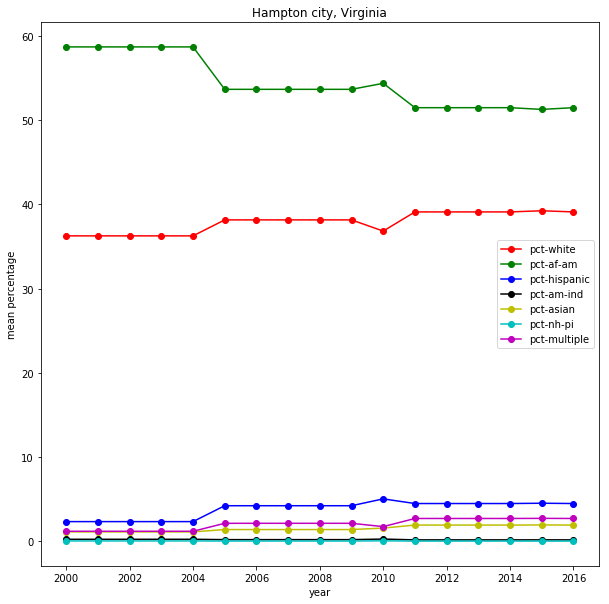

In [38]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
ax.plot(np.array(range(2000,2017)),by_year.mean()['pct-white'].as_matrix(),'-ro',label = 'pct-white')
ax.plot(np.array(range(2000,2017)),by_year.mean()['pct-af-am'].as_matrix(),'-go',label = 'pct-af-am')
ax.plot(np.array(range(2000,2017)),by_year.mean()['pct-hispanic'].as_matrix(),'-bo',label = 'pct-hispanic')
ax.plot(np.array(range(2000,2017)),by_year.mean()['pct-am-ind'].as_matrix(),'-ko',label = 'pct-am-ind')
ax.plot(np.array(range(2000,2017)),by_year.mean()['pct-asian'].as_matrix(),'-yo',label = 'pct-asian')
ax.plot(np.array(range(2000,2017)),by_year.mean()['pct-nh-pi'].as_matrix(),'-co',label = 'pct-nh-pi')
ax.plot(np.array(range(2000,2017)),by_year.mean()['pct-multiple'].as_matrix(),'-mo',label = 'pct-multiple')
plt.legend(fontsize="xx-large")
plt.title('Hampton city, Virginia')
plt.xlabel("year")
plt.ylabel("mean percentage")
ax.legend()
plt.show()
fig.savefig('Fig_VA_RichmondCity_races.jpg')

Text(0,0.5,'mean eviction-rate')

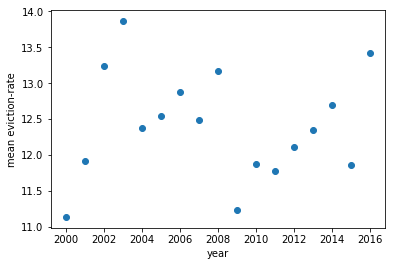

In [39]:
plt.scatter(np.array(range(2000,2017)),by_year.mean()['eviction-rate'].as_matrix())
plt.xlabel("year")
plt.ylabel('mean eviction-rate')

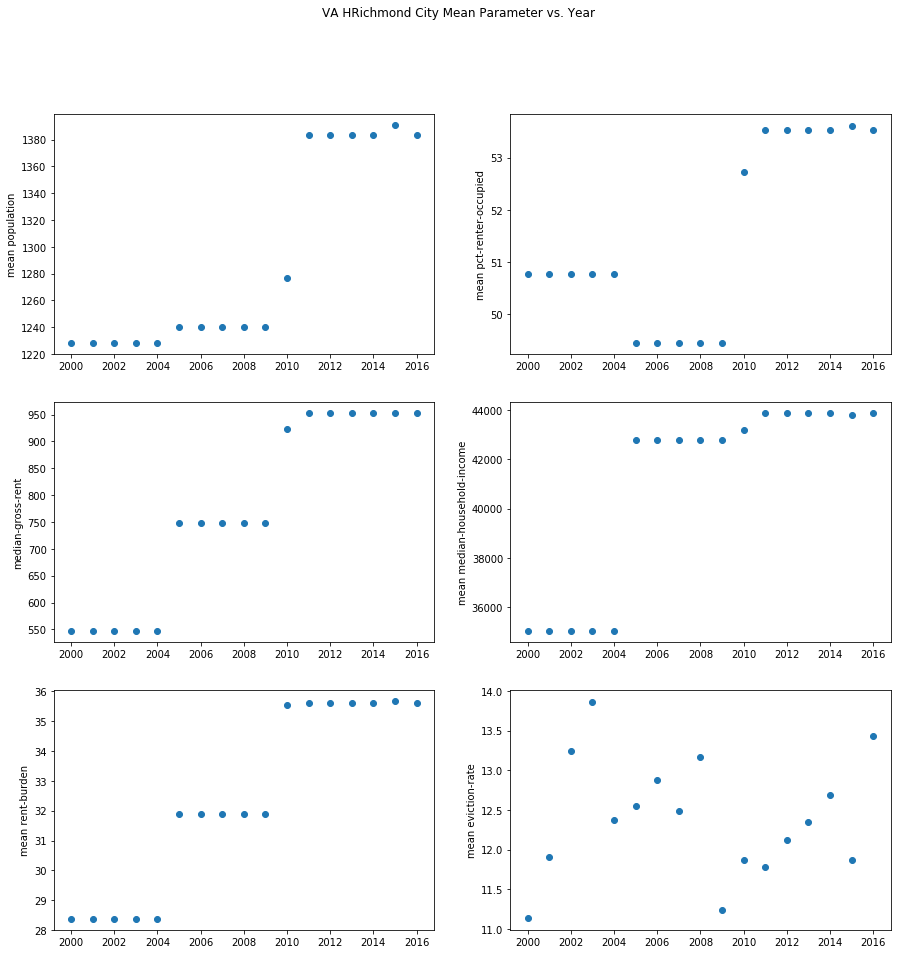

In [40]:
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(15,15))

fig.suptitle('VA HRichmond City Mean Parameter vs. Year')

ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()

ax0.scatter(np.array(range(2000,2017)),by_year.mean()['population'].as_matrix())
ax0.set_ylabel('mean population')

ax1.scatter(np.array(range(2000,2017)),by_year.mean()['pct-renter-occupied'].as_matrix())
ax1.set_ylabel('mean pct-renter-occupied')

ax2.scatter(np.array(range(2000,2017)),by_year.mean()['median-gross-rent'].as_matrix())
ax2.set_ylabel('median-gross-rent')

ax3.scatter(np.array(range(2000,2017)),by_year.mean()['median-household-income'].as_matrix())
ax3.set_ylabel('mean median-household-income')

ax4.scatter(np.array(range(2000,2017)),by_year.mean()['rent-burden'].as_matrix())
ax4.set_ylabel('mean rent-burden')

ax5.scatter(np.array(range(2000,2017)),by_year.mean()['eviction-rate'].as_matrix())
ax5.set_ylabel('mean eviction-rate')

fig.savefig('Fig_VA_RichmondCity_YearMean.jpg')